In [15]:
import numpy as np
import tensorflow as tf
import fakearray as fa
import matplotlib.pyplot as plt
from showit import image, tile

%matplotlib inline

In [76]:
shape = (28, 28)

In [77]:
data, series, sources = fa.calcium_imaging(shape, t=100, n=5, sd=2, withparams=True)
data = data.astype('float16')

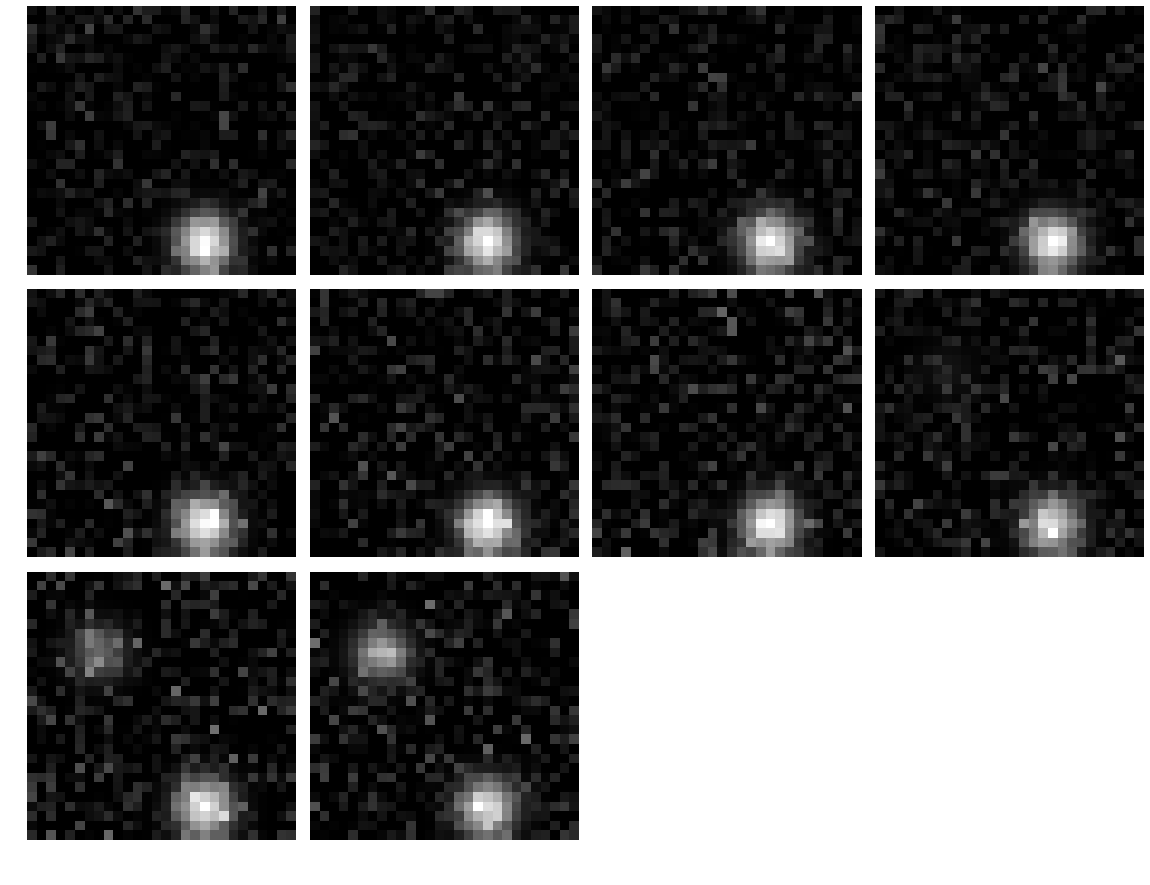

In [78]:
tile(data[:10, :, :], size=20);

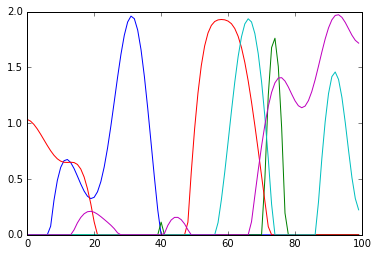

In [79]:
plt.plot(series.T);

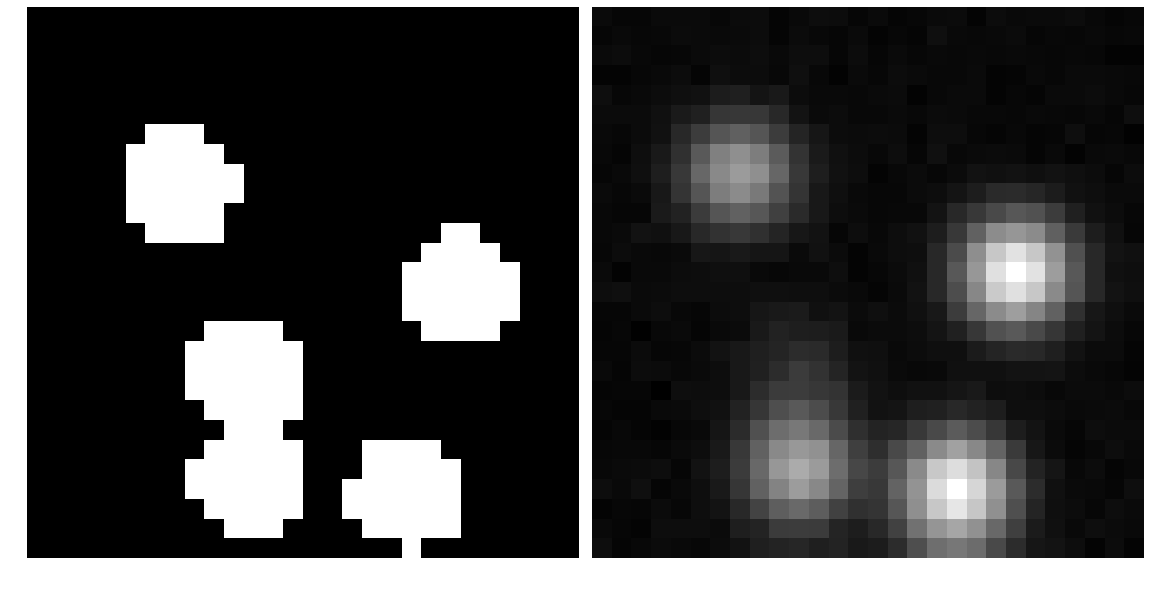

In [80]:
truth = np.zeros(data.shape[1:], dtype='bool')
for s in sources:
    for point in s:
        truth[point[0], point[1]] = 1

tile([truth, data.mean(axis=0)], size=20);

### training batch

In [123]:
x = tf.placeholder(tf.float16, shape=(None, shape[0], shape[1], 1))
y = tf.placeholder(tf.float16, shape=(None, shape[0], shape[1], 2))

### layer 1 (conv)

In [97]:
Nh1 = 24
W1 = tf.Variable(tf.truncated_normal((5, 5, 1, Nh1), dtype=tf.float16))
b1 = tf.Variable(tf.constant(0.1, shape=(Nh1, ), dtype=tf.float16))
h1 = tf.nn.conv2d(x, W1, [1, 1, 1, 1], 'SAME') + b1

### layer 2 (fully connected)

In [152]:
n1 = shape[0]*shape[1]*Nh1
n2 = shape[0]*shape[1]*2
h1_flat = tf.reshape(h1, (-1, n1))
W2 = tf.Variable(tf.truncated_normal((n1, n2), dtype=tf.float16))
b2 = tf.Variable(tf.constant(0.1, shape=(2, ), dtype=tf.float16))
yhat = tf.matmul(h1_flat, W2)
yhat = tf.reshape(yhat, (-1, shape[0], shape[1], 2)) + b2

### custom softmax

In [146]:
exp = tf.exp(yhat)
exp_sum = tf.expand_dims(tf.reduce_sum(exp, reduction_indices=3), 3)
phat = tf.div(exp, exp_sum)

In [151]:
ce = -tf.log(tf.reduce_sum(tf.mul(y, phat), reduction_indices=3))
c = tf.reduce_mean(ce)